In [6]:
import os, sys

from keras.models import Model
from keras.layers import Input, LSTM, GRU, Dense, Embedding
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt

In [7]:
BATCH_SIZE = 64
EPOCHS = 20
LSTM_NODES =256
NUM_SENTENCES = 20000
MAX_SENTENCE_LENGTH = 50
MAX_NUM_WORDS = 20000
EMBEDDING_SIZE = 100

In [8]:
file_path = '/content/spa.txt'


input_sentences = []
output_sentences = []
output_sentences_inputs = []

count = 0

with open(file_path, 'r', encoding='utf-8') as file:
    for line in file:
        count += 1
        if count > 5000:
            break

        if '\t' not in line:
            continue

        # Extracting the English and Hindi sentences from the line
        input_sentence, output, _ = line.rstrip().split('\t')

        output_sentence = output + ' <eos>'
        output_sentence_input = '<sos> ' + output

        input_sentences.append(input_sentence)
        output_sentences.append(output_sentence)
        output_sentences_inputs.append(output_sentence_input)

print("num samples input:", len(input_sentences))
print("num samples output:", len(output_sentences))
print("num samples output input:", len(output_sentences_inputs))


num samples input: 5000
num samples output: 5000
num samples output input: 5000


In [9]:
print(input_sentences[172])
print(output_sentences[172])
print(output_sentences_inputs[172])

Beat it!
¡Pírate! <eos>
<sos> ¡Pírate!


In [10]:
input_tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
input_tokenizer.fit_on_texts(input_sentences)
input_integer_seq = input_tokenizer.texts_to_sequences(input_sentences)

word2idx_inputs = input_tokenizer.word_index
print('Total unique words in the input: %s' % len(word2idx_inputs))

max_input_len = max(len(sen) for sen in input_integer_seq)
print("Length of longest sentence in input: %g" % max_input_len)

Total unique words in the input: 1280
Length of longest sentence in input: 4


In [11]:
output_tokenizer = Tokenizer(num_words=MAX_NUM_WORDS, filters='')
output_tokenizer.fit_on_texts(output_sentences + output_sentences_inputs)
output_integer_seq = output_tokenizer.texts_to_sequences(output_sentences)
output_input_integer_seq = output_tokenizer.texts_to_sequences(output_sentences_inputs)

word2idx_outputs = output_tokenizer.word_index
print('Total unique words in the output: %s' % len(word2idx_outputs))

num_words_output = len(word2idx_outputs) + 1
max_out_len = max(len(sen) for sen in output_integer_seq)
print("Length of longest sentence in the output: %g" % max_out_len)

Total unique words in the output: 3775
Length of longest sentence in the output: 9


In [12]:
encoder_input_sequences = pad_sequences(input_integer_seq, maxlen=max_input_len)
print("encoder_input_sequences.shape:", encoder_input_sequences.shape)
print("encoder_input_sequences[172]:", encoder_input_sequences[172])

encoder_input_sequences.shape: (5000, 4)
encoder_input_sequences[172]: [  0   0 504   3]


In [13]:
decoder_input_sequences = pad_sequences(output_input_integer_seq,
                                        maxlen=max_out_len, padding='post')
print("decoder_input_sequences.shape:", decoder_input_sequences.shape)
print("decoder_input_sequences[172]:", decoder_input_sequences[172])

decoder_input_sequences.shape: (5000, 9)
decoder_input_sequences[172]: [   2 1389    0    0    0    0    0    0    0]


In [14]:
#Padding the decoder outputs
decoder_output_sequences=pad_sequences(output_integer_seq,
                                       maxlen=max_out_len, padding='post')
print("decoder_output_sequences.shape:", decoder_output_sequences.shape)

decoder_output_sequences.shape: (5000, 9)


In [15]:
decoder_targets_one_hot = np.zeros((
        len(input_sentences),
        max_out_len,
        num_words_output
    ),
    dtype='float32'
)

In [16]:
for i, d in enumerate(decoder_output_sequences):
    for t, word in enumerate(d):
        decoder_targets_one_hot[i, t, word] = 1

In [17]:
num_words_output = len(word2idx_outputs) + 1
num_words_output

3776

In [18]:
encoder_inputs_placeholder = Input(shape=(max_input_len,))
x = Embedding(input_dim=2408, output_dim=100,input_length=max_input_len)
encoder = LSTM(LSTM_NODES, return_state=True)

encoder_outputs, h, c = encoder(x(encoder_inputs_placeholder))
encoder_states = [h, c]

In [19]:
decoder_inputs_placeholder = Input(shape=(max_out_len,))

decoder_embedding = Embedding(num_words_output,LSTM_NODES)
decoder_inputs_x = decoder_embedding(decoder_inputs_placeholder)

decoder_lstm = LSTM(LSTM_NODES, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs_x,
                                     initial_state=encoder_states)

In [20]:
decoder_dense = Dense(num_words_output, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

In [21]:
model = Model([encoder_inputs_placeholder,
  decoder_inputs_placeholder], decoder_outputs)
model.compile(
    optimizer='rmsprop',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

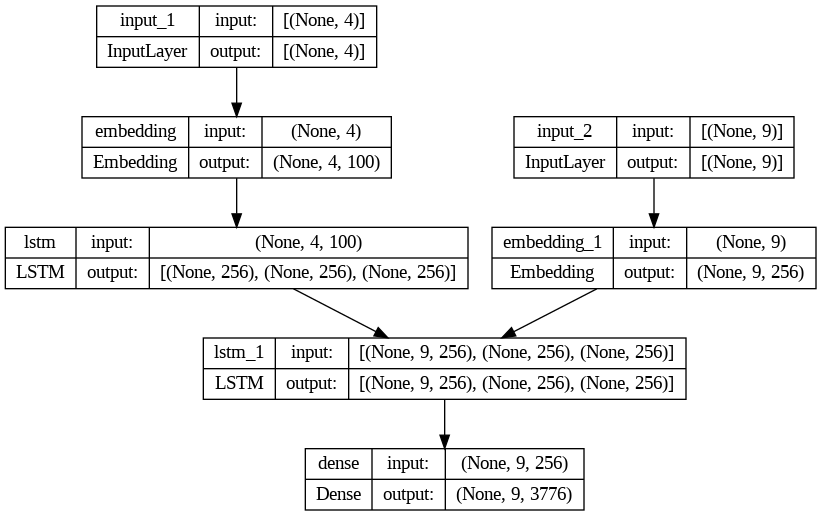

In [22]:
from keras.utils import plot_model
plot_model(model, to_file='model_plot4a.png', show_shapes=True,
           show_layer_names=True)

In [ ]:
model.fit(
    [encoder_input_sequences, decoder_input_sequences],
    decoder_targets_one_hot,
    batch_size=BATCH_SIZE,
    epochs=80,
    validation_split=0.1,
)

Epoch 1/80
71/71 [==============================] - 18s 260ms/step - loss: 1.8608 - accuracy: 0.7427 - val_loss: 2.1337 - val_accuracy: 0.7318
Epoch 2/80
71/71 [==============================] - 17s 230ms/step - loss: 1.8122 - accuracy: 0.7441 - val_loss: 2.1115 - val_accuracy: 0.7331
Epoch 3/80
71/71 [==============================] - 15s 217ms/step - loss: 1.7647 - accuracy: 0.7462 - val_loss: 2.0900 - val_accuracy: 0.7351
Epoch 4/80
71/71 [==============================] - 16s 224ms/step - loss: 1.7249 - accuracy: 0.7474 - val_loss: 2.0680 - val_accuracy: 0.7353
Epoch 5/80
71/71 [==============================] - 16s 225ms/step - loss: 1.6863 - accuracy: 0.7504 - val_loss: 2.0486 - val_accuracy: 0.7367
Epoch 6/80
71/71 [==============================] - 15s 211ms/step - loss: 1.6486 - accuracy: 0.7550 - val_loss: 2.0369 - val_accuracy: 0.7376
Epoch 7/80
41/71 [================>.............] - ETA: 5s - loss: 1.6117 - accuracy: 0.7562

In [ ]:
encoder_model = Model(encoder_inputs_placeholder, encoder_states)


In [ ]:
decoder_state_input_h = Input(shape=(LSTM_NODES,))
decoder_state_input_c = Input(shape=(LSTM_NODES,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

In [ ]:
decoder_inputs_single = Input(shape=(1,))
decoder_inputs_single_x = decoder_embedding(decoder_inputs_single)

In [ ]:
decoder_outputs, h, c = decoder_lstm(decoder_inputs_single_x,
                                     initial_state=decoder_states_inputs)


In [ ]:
decoder_states = [h, c]
decoder_outputs = decoder_dense(decoder_outputs)

In [ ]:
decoder_model = Model(
    [decoder_inputs_single] + decoder_states_inputs,
    [decoder_outputs] + decoder_states
)

In [ ]:
from keras.utils import plot_model
plot_model(decoder_model, to_file='model_plot_dec.png',
           show_shapes=True, show_layer_names=True)

In [ ]:
idx2word_input = {v:k for k, v in word2idx_inputs.items()}
idx2word_target = {v:k for k, v in word2idx_outputs.items()}

In [ ]:

def translate_sentence(input_seq):
    states_value = encoder_model.predict(input_seq)
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = word2idx_outputs['<sos>']
    eos = word2idx_outputs['<eos>']
    output_sentence = []

    for _ in range(max_out_len):
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)
        idx = np.argmax(output_tokens[0, 0, :])

        if eos == idx:
            break

        word = ''

        if idx > 0:
            word = idx2word_target[idx]
            output_sentence.append(word)

        target_seq[0, 0] = idx
        states_value = [h, c]

    return ' '.join(output_sentence)

In [ ]:
i = np.random.choice(len(input_sentences))
input_seq = encoder_input_sequences[i:i+1]
translation = translate_sentence(input_seq)
print('-')
print('Input:', input_sentences[i])
print('Response:', translation)